In [1]:
import os
import pandas as pd
import cooler 
import cooltools
import numpy as np
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import register_cmap
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 12})

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

save_folder = '../paper_figures'
load_folder = '../data/' 

### Plotting helper functions

In [2]:
# set colour map for Hi-C
hic_cmap_colours = [(255, 255, 255),(162, 192, 222),(140, 137, 187),\
         (140, 87, 167),(140, 45, 143),(120, 20, 120), \
         (90, 15, 90), (60, 10, 60), (30, 5, 30), (0, 0, 0)]
hic_cmap_colours = [(x[0]/255,x[1]/255,x[2]/255) for x in hic_cmap_colours]
tung_map = LinearSegmentedColormap.from_list('tung', hic_cmap_colours, 256)
register_cmap('tung', tung_map)

#  helper function for plotting
def gridspec_inches(wcols, hrows, wspace=0.5, hspace=0.5, fig_kwargs={}):
    """
    Output
    ------
    fig : figure handle
    
    gs : gridspec handle to be used in plt.subplot(gs[index])    
    """
        
    fig = plt.figure()
    fig_height_inches = (sum(hrows))
    fig_width_inches = (sum(wcols))

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=matplotlib.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=wspace,
        hspace=hspace,
        width_ratios=wcols,
        height_ratios=hrows
        )
    return fig, gs

## Load the Hi-C data and get P(s) curves

In [3]:
all_coolers = [f for f in os.listdir(load_folder) if '.mcool' in f]
c_dict = {}
resolution = 5000
for f in all_coolers:
    c = cooler.Cooler(load_folder + f+f'::/resolutions/{resolution}')
    M = c.matrix().fetch('Ch1')
    c_dict[f] = M 

    
pc_dict = {}
for fi, f in enumerate(sorted(all_coolers)):
    M = c_dict[f]
    pc = np.zeros( len(M)-1)
    for k in range(len(M)-1):
        pc[k] = np.nanmean(np.diag(M,k))
    pc_dict[f] = pc
    

## K-means method with Elbow and Silhouette scores to cluster Hi-C data

Text(0.5, 1.0, 'Silhouette method')

<Figure size 640x480 with 0 Axes>

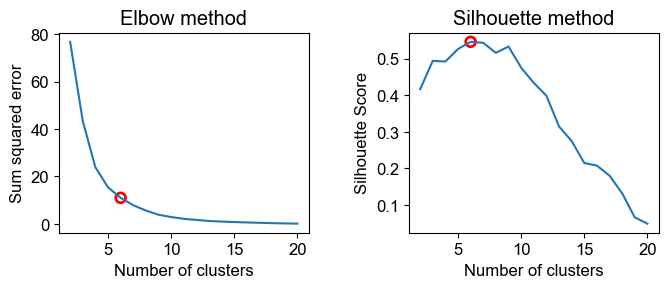

In [4]:
numX = 2
numY = 1
plot_inches = 2

fig, gs = gridspec_inches([plot_inches*1.5]*numX,[plot_inches]*numY,wspace=0.4,hspace=0.3)

sse = {}
sil = {}
lab = {}

# use k-means and the silhouette scores on the log derivative of the P(s) curves to cluster data 
X = [np.log(pc_dict[k]) for k in pc_dict.keys()]
data = X
cluster_range = range(2, 21)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    cluster_labels = kmeans.fit_predict(data)
    sse[k] = kmeans.inertia_ 
    silhouette_avg = silhouette_score(data, cluster_labels)
    sil[k] = silhouette_avg
    lab[k] = kmeans.labels_    
    
# elbow method plot
plt.subplot(gs[0])
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum squared error")
plt.scatter(list(sse.keys())[4], list(sse.values())[4], s=50, facecolors='none', edgecolors='r',linewidth=2)
plt.title('Elbow method')

# silhouette score plot
plt.subplot(gs[1])
plt.plot(list(sil.keys()), list(sil.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.scatter(list(sil.keys())[np.argmax(list(sil.values()))], list(sil.values())[np.argmax(list(sil.values()))], s=50, facecolors='none', edgecolors='r',linewidth=2)
plt.title('Silhouette method')

# plt.savefig(save_folder + f'Elbow_and_silhouette_scores.pdf',bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

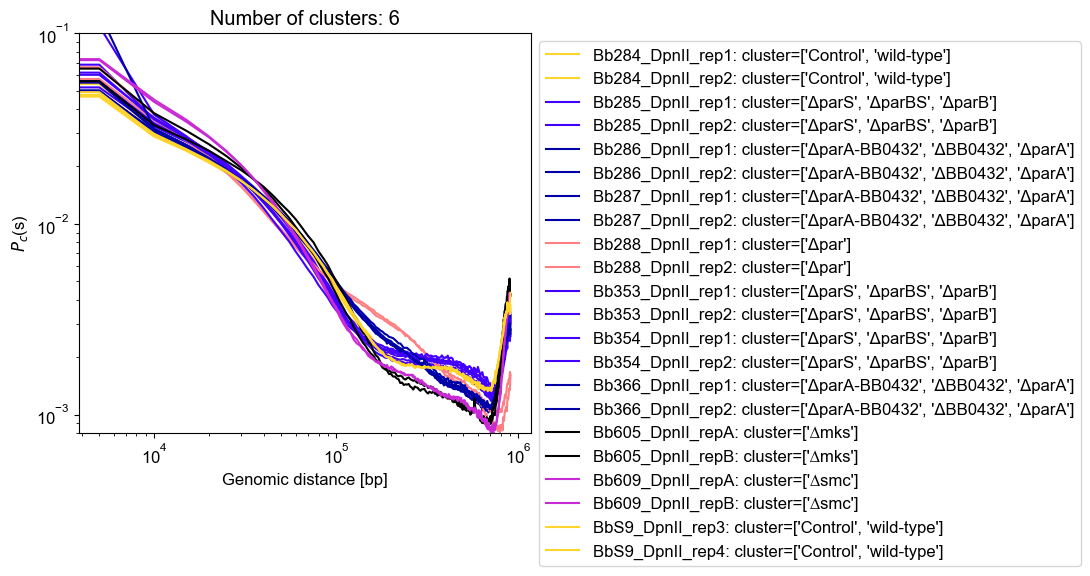

In [5]:
# load the genotype data
df = pd.read_excel('Borrelia genotypes.xlsx')
cmap = matplotlib.cm.gnuplot2

# visualize different clusterings
plot_inches = 4
for num_clust in [6]:
    
    # get cluster group names
    groups = {k:[] for k in range(num_clust)}
    groups_raw = {k:[] for k in range(num_clust)}
    for clust, name in zip(lab[num_clust], sorted(all_coolers)):
        genotype = df[df.Strain.str.contains(name.split('_')[0])].genometype.values[0]
        groups[clust].append(genotype)
        groups_raw[clust].append(name)
    groups = {k:list(set(groups[k])) for k in groups.keys()}

    fig, gs = gridspec_inches([plot_inches*1.3]*numX,[plot_inches]*numY,wspace=0.3,hspace=0.3)
    plt.subplot(gs[0])
    for fi, (clust_label, f) in enumerate(zip(lab[num_clust],sorted(all_coolers))):
        pc = pc_dict[f]
        plt.loglog(np.arange(len(pc))*resolution,pc,label=f.split('.')[0]+f': cluster={groups[clust_label]}',color=cmap(clust_label/num_clust))
        plt.ylabel('$P_c$(s)')
        plt.xlabel('Genomic distance [bp]')
        plt.ylim([8e-4,1e-1])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.title(f"Number of clusters: {num_clust}")
    #plt.savefig(save_folder+f'Kmeans_clustering_numClusters={num_clust}.pdf',bbox_inches='tight')

In [6]:
# What genotypes cluster together?
num_clust = 6
groups = {k:[] for k in range(num_clust)}
groups_raw = {k:[] for k in range(num_clust)}
for clust, name in zip(lab[num_clust], sorted(all_coolers)):
    genotype = df[df.Strain.str.contains(name.split('_')[0])].genometype.values[0]
    groups[clust].append(genotype)
    groups_raw[clust].append(name)
groups = {k:list(set(groups[k])) for k in groups.keys()}
groups    

{0: ['∆mks'],
 1: ['ΔparA-BB0432', 'ΔBB0432', 'ΔparA'],
 2: ['ΔparS', 'ΔparBS', 'ΔparB'],
 3: ['∆smc'],
 4: ['Δpar'],
 5: ['Control', 'wild-type']}

## Plot the Hi-C data and P(s) curves

In [7]:
ordering = [['BbS9_DpnII_rep3.BbS9.mapq_30.1000.mcool','BbS9_DpnII_rep4.BbS9.mapq_30.1000.mcool'],
            ['Bb284_DpnII_rep1.BbS9.mapq_30.1000.mcool','Bb284_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb353_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb353_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb354_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb354_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb285_DpnII_rep1.BbS9.mapq_30.1000.mcool','Bb285_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb366_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb366_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            [ 'Bb286_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb286_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb287_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb287_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            [ 'Bb288_DpnII_rep1.BbS9.mapq_30.1000.mcool', 'Bb288_DpnII_rep2.BbS9.mapq_30.1000.mcool'],
            ['Bb609_DpnII_repA.BbS9.mapq_30.1000.mcool', 'Bb609_DpnII_repB.BbS9.mapq_30.1000.mcool'],
            [ 'Bb605_DpnII_repA.BbS9.mapq_30.1000.mcool', 'Bb605_DpnII_repB.BbS9.mapq_30.1000.mcool'],
           ]

ordered_names = ['WT (S9)', 'control (284)', '∆parB(353)',
'∆parS (354)', '∆parBS (285)','∆parA(366)','∆parZ(286)',
'∆parAZ (287)', '∆par(288)', '∆smc(609)', '∆mks (605)']

In [8]:
# load the Hi-C data and combine biological replicates 
c_dict = {}
folder = load_folder
resolution = 5000
for this_strain, this_name in zip(ordering,ordered_names):
    for fi, f in enumerate(this_strain):
        c = cooler.Cooler(folder + f+f'::/resolutions/{resolution}')
        M = c.matrix().fetch('Ch1')
        if fi == 0:
            c_dict[this_name] = M/len(this_strain)
        else:
            c_dict[this_name] += M/len(this_strain)

<Figure size 640x480 with 0 Axes>

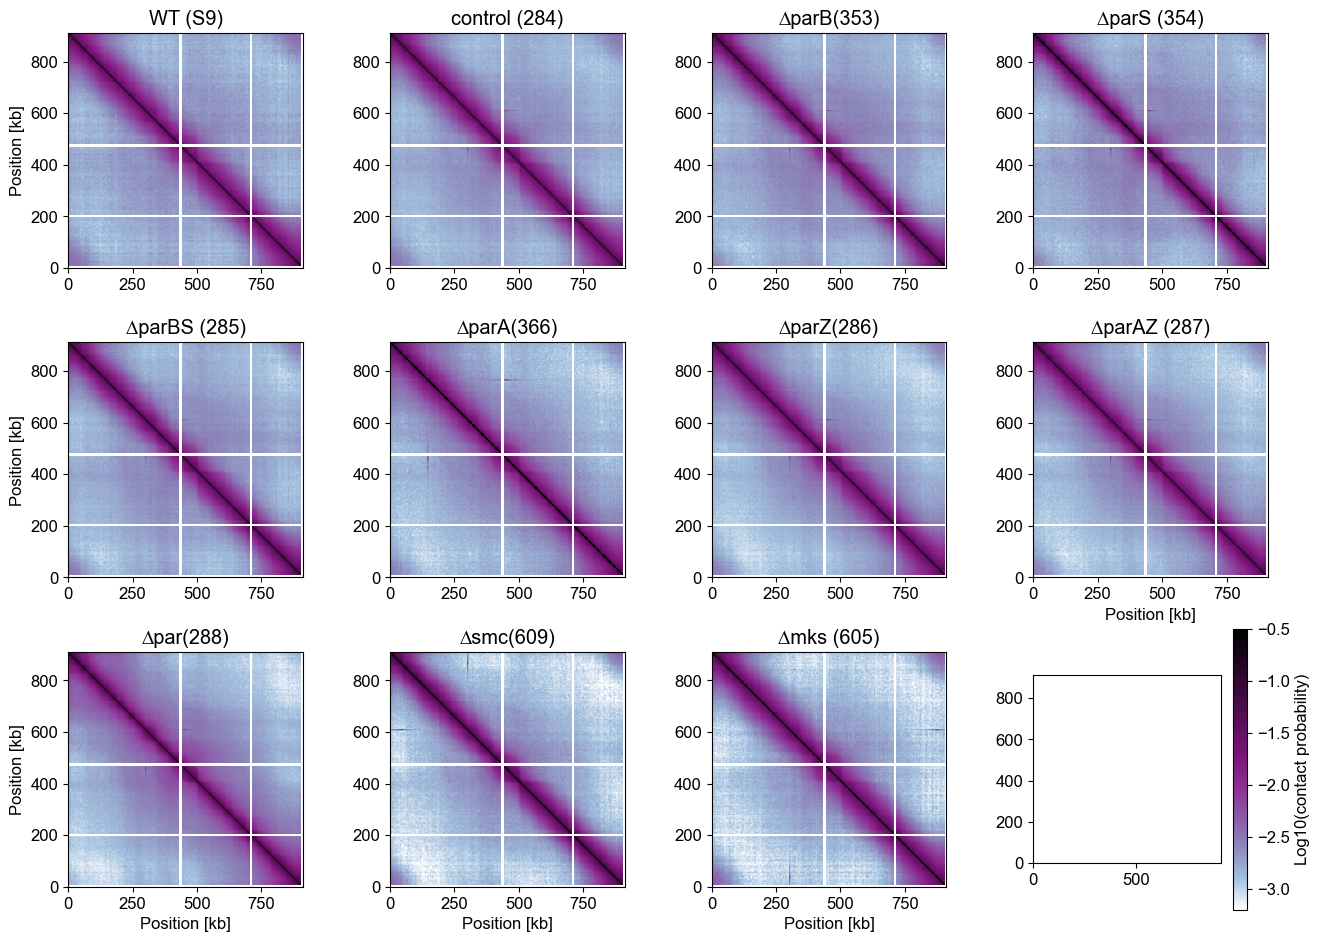

In [9]:

fig, gs = gridspec_inches([3]*4,[3]*3,wspace=0.37,hspace=0.1)
for fi, f in enumerate(c_dict.keys()):
    plt.subplot(gs[fi])
    M = c_dict[f]
    plt.imshow(np.log10(M),vmax=-0.5,vmin=-3.2,cmap='tung',extent=[0,c.chromsizes['Ch1']/1000,0,c.chromsizes['Ch1']/1000])
    plt.title(f.split('.')[0])
    if np.mod(fi,4)==0:
        plt.ylabel('Position [kb]')
    if len(c_dict.keys())-4 <= fi:
        plt.xlabel('Position [kb]')
  
plt.subplot(gs[fi+1])
plt.imshow(np.log10(np.zeros_like(M)),vmax=-0.5,vmin=-3.2,cmap='tung',extent=[0,c.chromsizes['Ch1']/1000,0,c.chromsizes['Ch1']/1000])
plt.colorbar(label='Log10(contact probability)')
#plt.savefig(os.path.join(save_folder, f'HiC_strains_overview_11.pdf'),bbox_inches='tight')    



<Figure size 640x480 with 0 Axes>

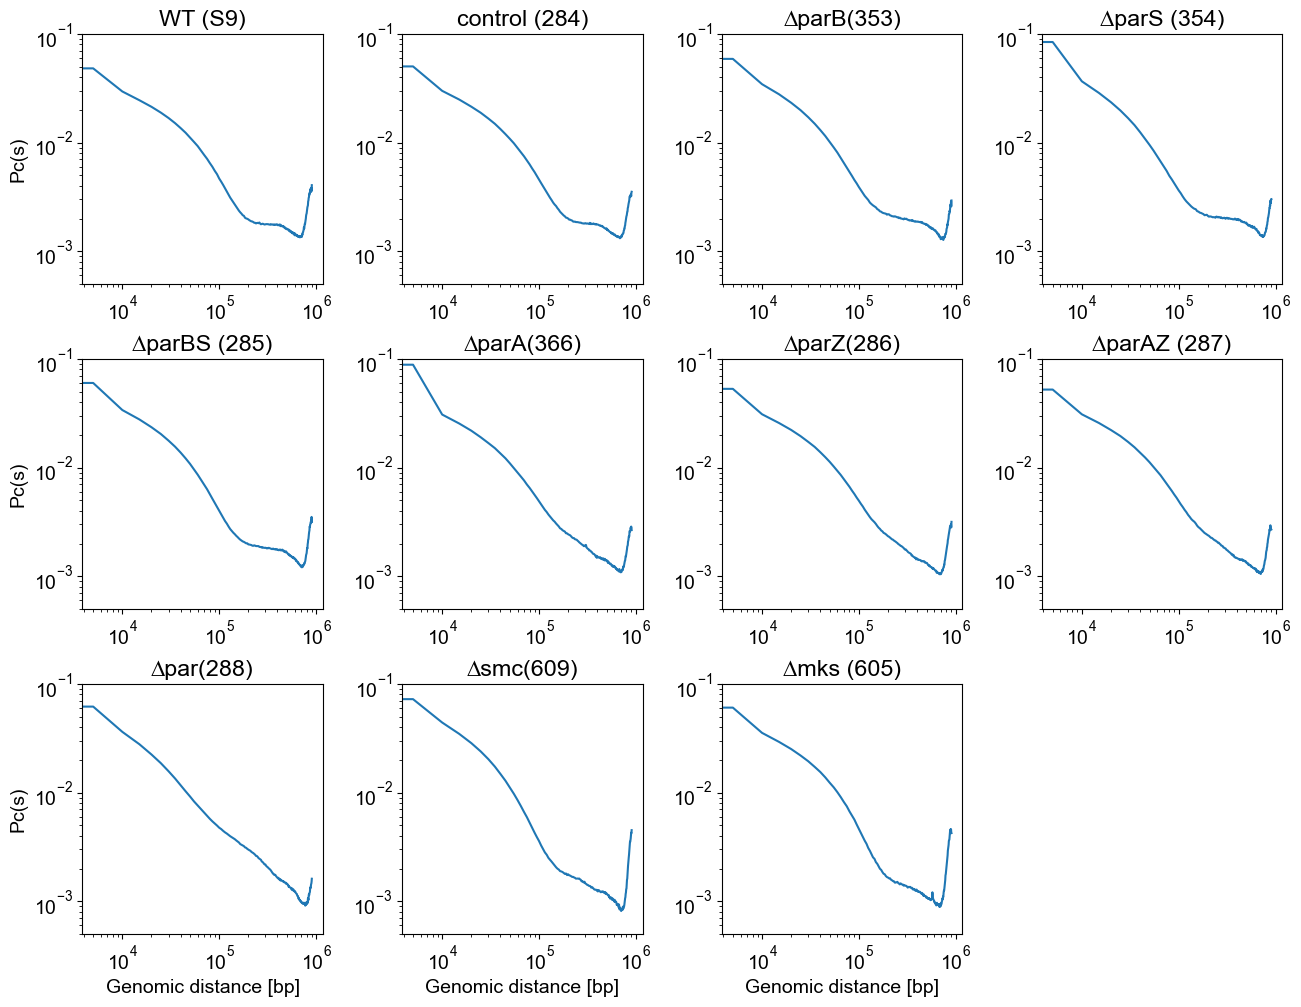

In [10]:
# plot the contact probability decay curves    
plt.rcParams.update({'font.size': 14})
numX = 4
numY = 3
fig, gs = gridspec_inches([3]*numX,[3]*numY,wspace=0.33,hspace=0.3)
pc_dict = {}
for fi, f in enumerate(c_dict.keys()):
    plt.subplot(gs[fi])
    M = c_dict[f]
    pc = np.zeros( len(M)-1)
    for k in range(len(M)-1):
        pc[k] = np.nanmean(np.diag(M,k))
    pc_dict[f] = pc
    plt.loglog(np.arange(len(pc))*resolution,pc)
    plt.title(f.split('.')[0])
    plt.ylim([5e-4,1e-1])
    if np.mod(fi,numX) == 0:
        plt.ylabel('Pc(s)')
    if fi >= (numY-1)*numX:
        plt.xlabel('Genomic distance [bp]')
#plt.savefig(os.path.join(save_folder, f'Pcs_strains_overview_11.pdf'),bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

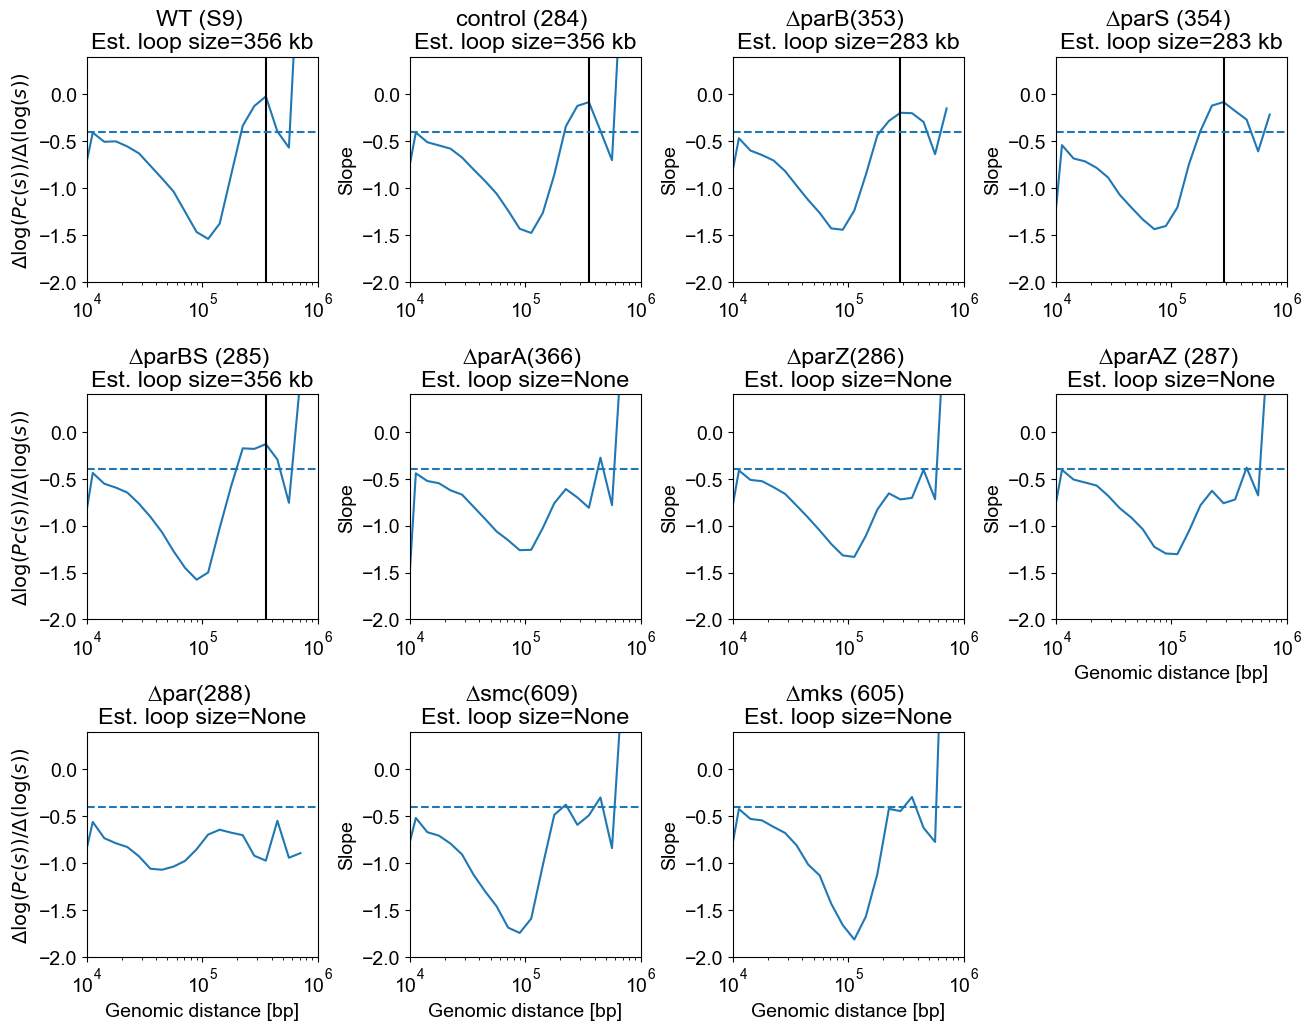

In [11]:
# plot the log-derivative of the Pc(s) curve
# estimate the loop size
numX = 4
numY = 3
c_dict = {}
resolution = 5000
for this_strain, this_name in zip(ordering,ordered_names):
    for fi, f in enumerate(this_strain):
        c = cooler.Cooler(folder + f+f'::/resolutions/{resolution}')
        M = c.matrix().fetch('Ch1')
        if fi == 0:
            c_dict[this_name] = M/len(this_strain)
        else:
            c_dict[this_name] += M/len(this_strain)

pc_dict = {}
for fi, f in enumerate(c_dict.keys()):
    M = c_dict[f]
    pc = np.zeros( len(M)-1)
    for k in range(len(M)-1):
        pc[k] = np.nanmean(np.diag(M,k))
    pc_dict[f] = pc
    
step_size = 0.1 # step size in log10(s)
fig, gs = gridspec_inches([3]*numX,[3]*numY,wspace=0.4,hspace=0.5)
for fi, f in enumerate(c_dict.keys()):
    plt.subplot(gs[fi])
    pc = pc_dict[f]
    
    # get interpolation function for Pc(s)
    interp = interp1d(np.arange(len(pc))*resolution,pc)
    xquery = 10**np.arange(np.log10(5000),np.log10(np.max(len(pc)*resolution)),step_size) # target range for the derivative analysis

    # compute the slope from the interpolation function
    slope = np.diff(np.log10(interp(xquery)))/step_size#np.diff(np.log10(xquery))
    plt.semilogx((xquery[0:-1]+xquery[1:])/2,slope)
    plt.ylabel('Slope')
    minX = np.sum(xquery<1e5)
    maxX = np.sum(xquery<=4.5e5)
    maxL = np.argmax(slope[minX:maxX])
    maxS = np.max(slope[minX:maxX])
    loop_size = (xquery[minX+maxL]+xquery[minX+maxL+1])/2
    if maxS > -0.25:
        plt.title(f"{f.split('.')[0]} \nEst. loop size={int(np.round(loop_size/1000))} kb")
        plt.axvline(loop_size,color='k')
    else:
        plt.title(f"{f.split('.')[0]} \nEst. loop size=None")
    plt.ylim([-2,0.4])
    plt.xlim([2*resolution,1e6])
    plt.axhline(-0.4,linestyle='--')
    if np.mod(fi,numX) == 0:
        plt.ylabel(r'$\Delta \log(Pc(s))/\Delta(\log(s))$')
    if fi >= len(ordering)-numX:
        plt.xlabel('Genomic distance [bp]')
#plt.savefig(os.path.join(save_folder, f'Loop_size_estimates_overview_11_conservative.pdf'),bbox_inches='tight')        
plt.show()

## Plot mean interactions of plasmids with the chromosome

In [14]:
plt.rcParams.update({'font.size': 14})
plasmid_dict = {}
resolution = 5000
for this_strain, this_name in zip(ordering,ordered_names):
    for fi, f in enumerate(this_strain):
        c = cooler.Cooler(folder + f+f'::/resolutions/{resolution}')

        chrom_names = sorted(c.chromnames)
        if fi == 0:    
            plasmid_dict[this_name] = {}
        for p in chrom_names[1:]:
            chrom_vs_plasmid = np.nanmean(c.matrix(balance=True).fetch(chrom_names[0],p),axis=1)
            if fi == 0:
                plasmid_dict[this_name][p] = chrom_vs_plasmid/len(this_strain)
            else:
                plasmid_dict[this_name][p] += chrom_vs_plasmid/len(this_strain)

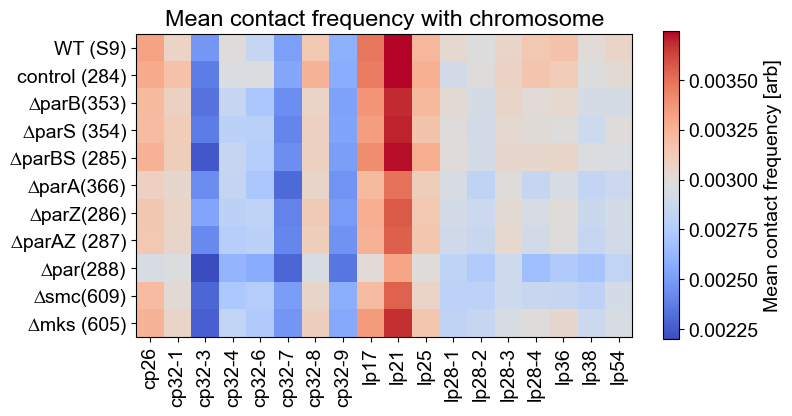

In [15]:
# Mean contact frequency with the chromosome
plt.figure(figsize=(8,4))
sum_total = np.zeros((len(plasmid_dict.keys()),len(chrom_names)-1))
plasmid_names = sorted(plasmid_dict.keys())
names = ordered_names #[f for f in plasmid_names]
for fi,f in enumerate(ordered_names): 
    X = [plasmid_dict[f][k] for k in plasmid_dict[f].keys()]
    sum_total[fi,:] = np.nanmean(X,axis=1)
plt.imshow(sum_total,cmap='coolwarm')#,vmax=0.00,vmin=0)
plt.yticks(np.arange(0,len(names)),labels=names)
plt.xticks(np.arange(0,len(X)),labels=chrom_names[1:],rotation=90)
plt.title('Mean contact frequency with chromosome')
plt.colorbar(label='Mean contact frequency [arb]') 
#plt.savefig(os.path.join(save_folder, f'Mean_plasmid_vs_chromosome_contact_frequency_averaged.pdf'),bbox_inches='tight')
plt.show()

## Plasmid interactions with chromosome by position 

In [16]:
plasmid_dict = {}
plasmid_plasmid_dict = {}

resolution = 5000
for gi, this_strain, this_name in zip(range(len(ordering)),ordering,ordered_names):
    for fi, f in enumerate(this_strain):
        c = cooler.Cooler(folder + f+f'::/resolutions/{resolution}')

        chrom_names = sorted(c.chromnames)
        if fi == 0:    
            plasmid_dict[this_name] = {}
            plasmid_plasmid_dict[this_name] = {}
            
        for p in chrom_names[1:]:
            chrom_vs_plasmid = np.nanmean(c.matrix(balance=True).fetch(chrom_names[0],p),axis=1)
            if fi == 0:
                plasmid_dict[this_name][p] = chrom_vs_plasmid/len(this_strain)
            else:
                plasmid_dict[this_name][p] += chrom_vs_plasmid/len(this_strain)
        
        for p1i, p1 in enumerate(chrom_names[1:]):
            for p2 in chrom_names[1+p1i+1:]:
                M = c.matrix(balance=True).fetch(p1,p2)
                M[M==0] = np.nan
                plasmid_vs_plasmid = np.nanmean(M)
                plasmid_plasmid_dict[this_name][(p1,p2)] = plasmid_vs_plasmid 
        

<Figure size 640x480 with 0 Axes>

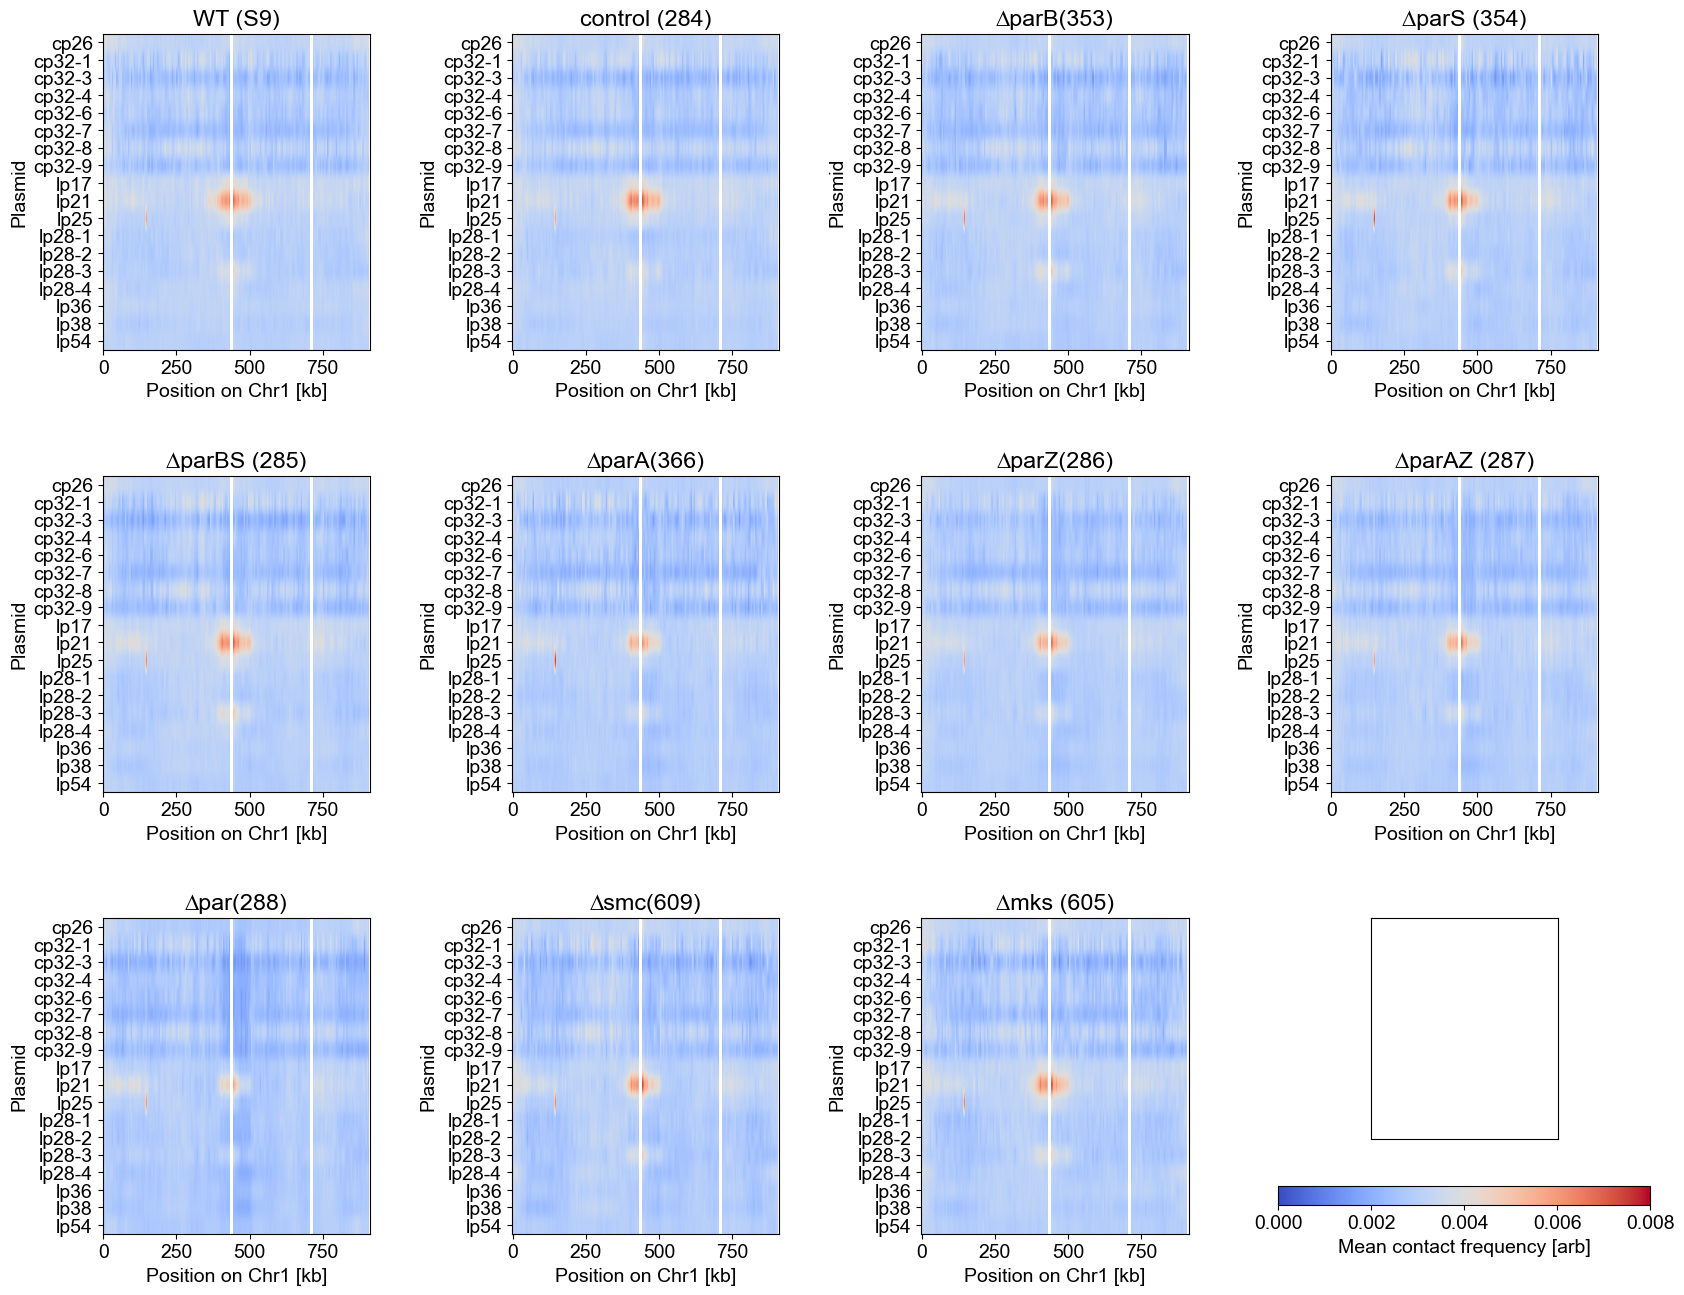

In [17]:
numX = 4
numY = 3
fig, gs = gridspec_inches([4]*numX,[4]*numY,wspace=0.1,hspace=0.4)

plt.rcParams.update({'font.size': 14})

for gi, this_strain, this_name in zip(range(len(ordering)),ordering,ordered_names):
    plt.subplot(gs[gi])
    X = [plasmid_dict[this_name][k] for k in plasmid_dict[this_name].keys()]
    plt.imshow(X,cmap='coolwarm',aspect=12,vmax=0.008,vmin=0)
    plt.xticks(np.arange(0,X[0].shape[0],50),[int(i) for i in np.arange(0,X[0].shape[0],50)*resolution/1000])
    plt.yticks(np.arange(0,len(X)),labels=chrom_names[1:])
    plt.ylabel('Plasmid')    
    plt.xlabel('Position on Chr1 [kb]')
    
    plt.title(this_name)
    this_name = f.split('(')[0]
    
plt.subplot(gs[gi+1])    
plt.imshow(np.log(np.zeros_like(X)),cmap='coolwarm',aspect=12,vmax=0.008,vmin=0) 
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.colorbar(orientation='horizontal',label='Mean contact frequency [arb]')  
this_name = f.split('(')[0]
# plt.savefig(os.path.join(save_folder, f'Chromosome_plasmid_interaction_combined.pdf'),bbox_inches='tight')

## Plasmid-plasmid interactions

<Figure size 640x480 with 0 Axes>

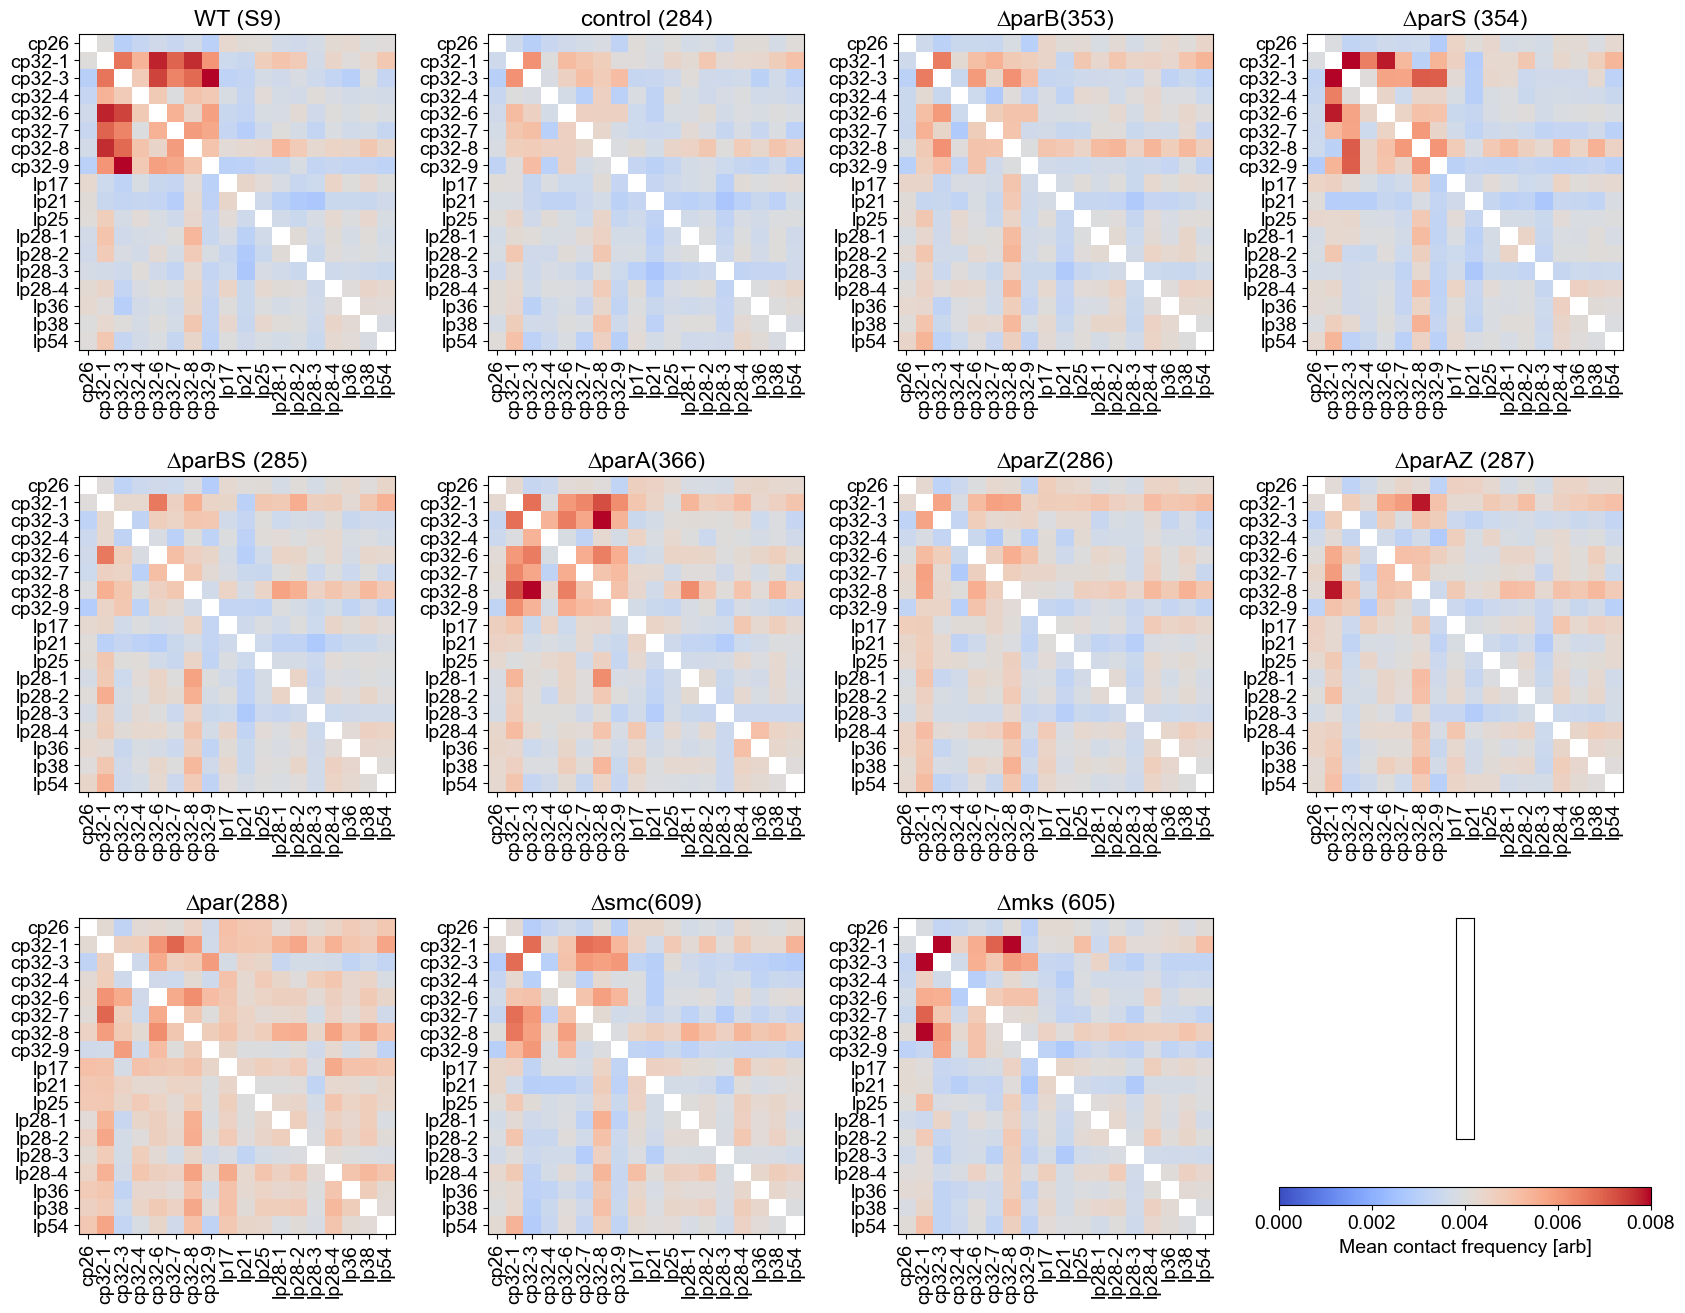

In [18]:
numX = 4
numY = 3
vmax=0.008
fig, gs = gridspec_inches([4]*numX,[4]*numY,wspace=0.1,hspace=0.4)
chrom_names = sorted(chrom_names)
for gi, this_strain, this_name in zip(range(len(ordering)),ordering,ordered_names):
    plt.subplot(gs[gi])
    M = np.zeros((len(chrom_names)-1,len(chrom_names)-1))*np.nan
    for p1i, p1 in enumerate(sorted(chrom_names[1:])):
        for p2i, p2 in enumerate(sorted(chrom_names[1+p1i+1:])):
            val = plasmid_plasmid_dict[this_name][(p1,p2)]         
            M[p1i,p1i+1+p2i] =  val
            M[p1i+1+p2i,p1i] = val
    plt.imshow(M,cmap='coolwarm',vmin=0,vmax=vmax,origin='upper')#,vmax=0.008)
    plt.title(this_name)
    plt.yticks(np.arange(0,len(chrom_names[1:])),labels=chrom_names[1:])
    plt.xticks(np.arange(0,len(chrom_names[1:])),labels=chrom_names[1:],rotation=90)
        
plt.subplot(gs[gi+1])        
plt.imshow(np.log(np.zeros_like(M)),cmap='coolwarm',aspect=12,vmax=vmax,vmin=0) 
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.colorbar(orientation='horizontal',label='Mean contact frequency [arb]')  
#plt.savefig(os.path.join(save_folder, f'Plasmid_plasmid_interaction_combined.pdf'),bbox_inches='tight')
# plt.show()

<Figure size 640x480 with 0 Axes>

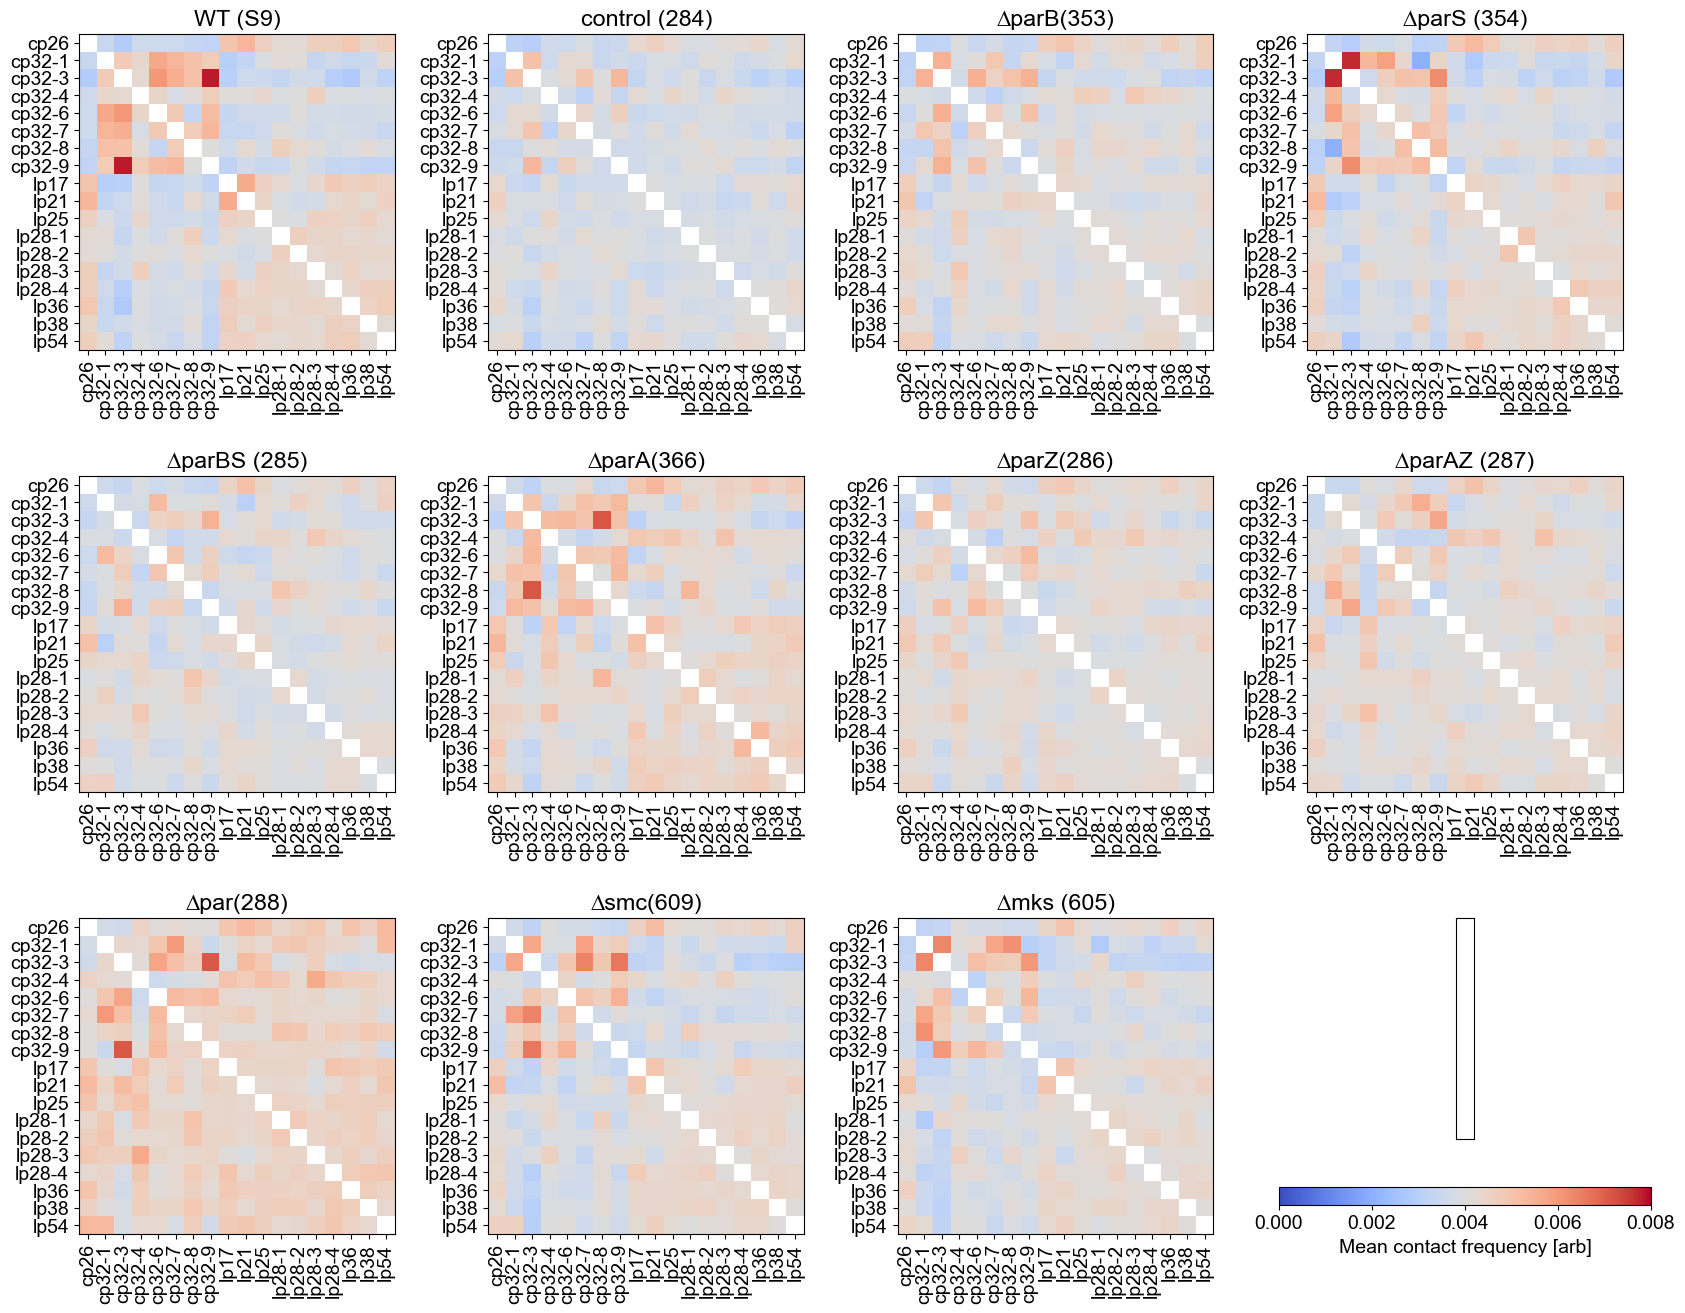

In [19]:
numX = 4
numY = 3
vmax = 0.008
fig, gs = gridspec_inches([4]*numX,[4]*numY,wspace=0.1,hspace=0.4)
chrom_names = sorted(chrom_names)
for gi, this_strain, this_name in zip(range(len(ordering)),ordering,ordered_names):
    plt.subplot(gs[gi])
    M = np.zeros((len(chrom_names)-1,len(chrom_names)-1))*np.nan
    for p1i, p1 in enumerate(sorted(chrom_names[1:])):
        for p2i, p2 in enumerate(sorted(chrom_names[1+p1i+1:])):
            val = plasmid_plasmid_dict[this_name][(p1,p2)]         
            M[p1i,p1i+1+p2i] =  val
            M[p1i+1+p2i,p1i] = val
            
    res= cooltools.numutils.iterative_correction_symmetric(M,ignore_diags=1)
    
    M = res[0]
    M[M==0] = np.nan
    plt.imshow(M,cmap='coolwarm',vmin=0,vmax=vmax,origin='upper')#,vmax=0.008)
    plt.title(this_name)
    plt.yticks(np.arange(0,len(chrom_names[1:])),labels=chrom_names[1:])
    plt.xticks(np.arange(0,len(chrom_names[1:])),labels=chrom_names[1:],rotation=90)
        
plt.subplot(gs[gi+1])        
plt.imshow(np.log(np.zeros_like(M)),cmap='coolwarm',aspect=12,vmax=vmax,vmin=0) 
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.colorbar(orientation='horizontal',label='Mean contact frequency [arb]')  
# plt.savefig(os.path.join(save_folder, f'Plasmid_plasmid_interaction_combined_rebalanced.pdf'),bbox_inches='tight')

# plt.show()

## Plasmid interactions with the chromosome by position, separated by plasmid type

<Figure size 640x480 with 0 Axes>

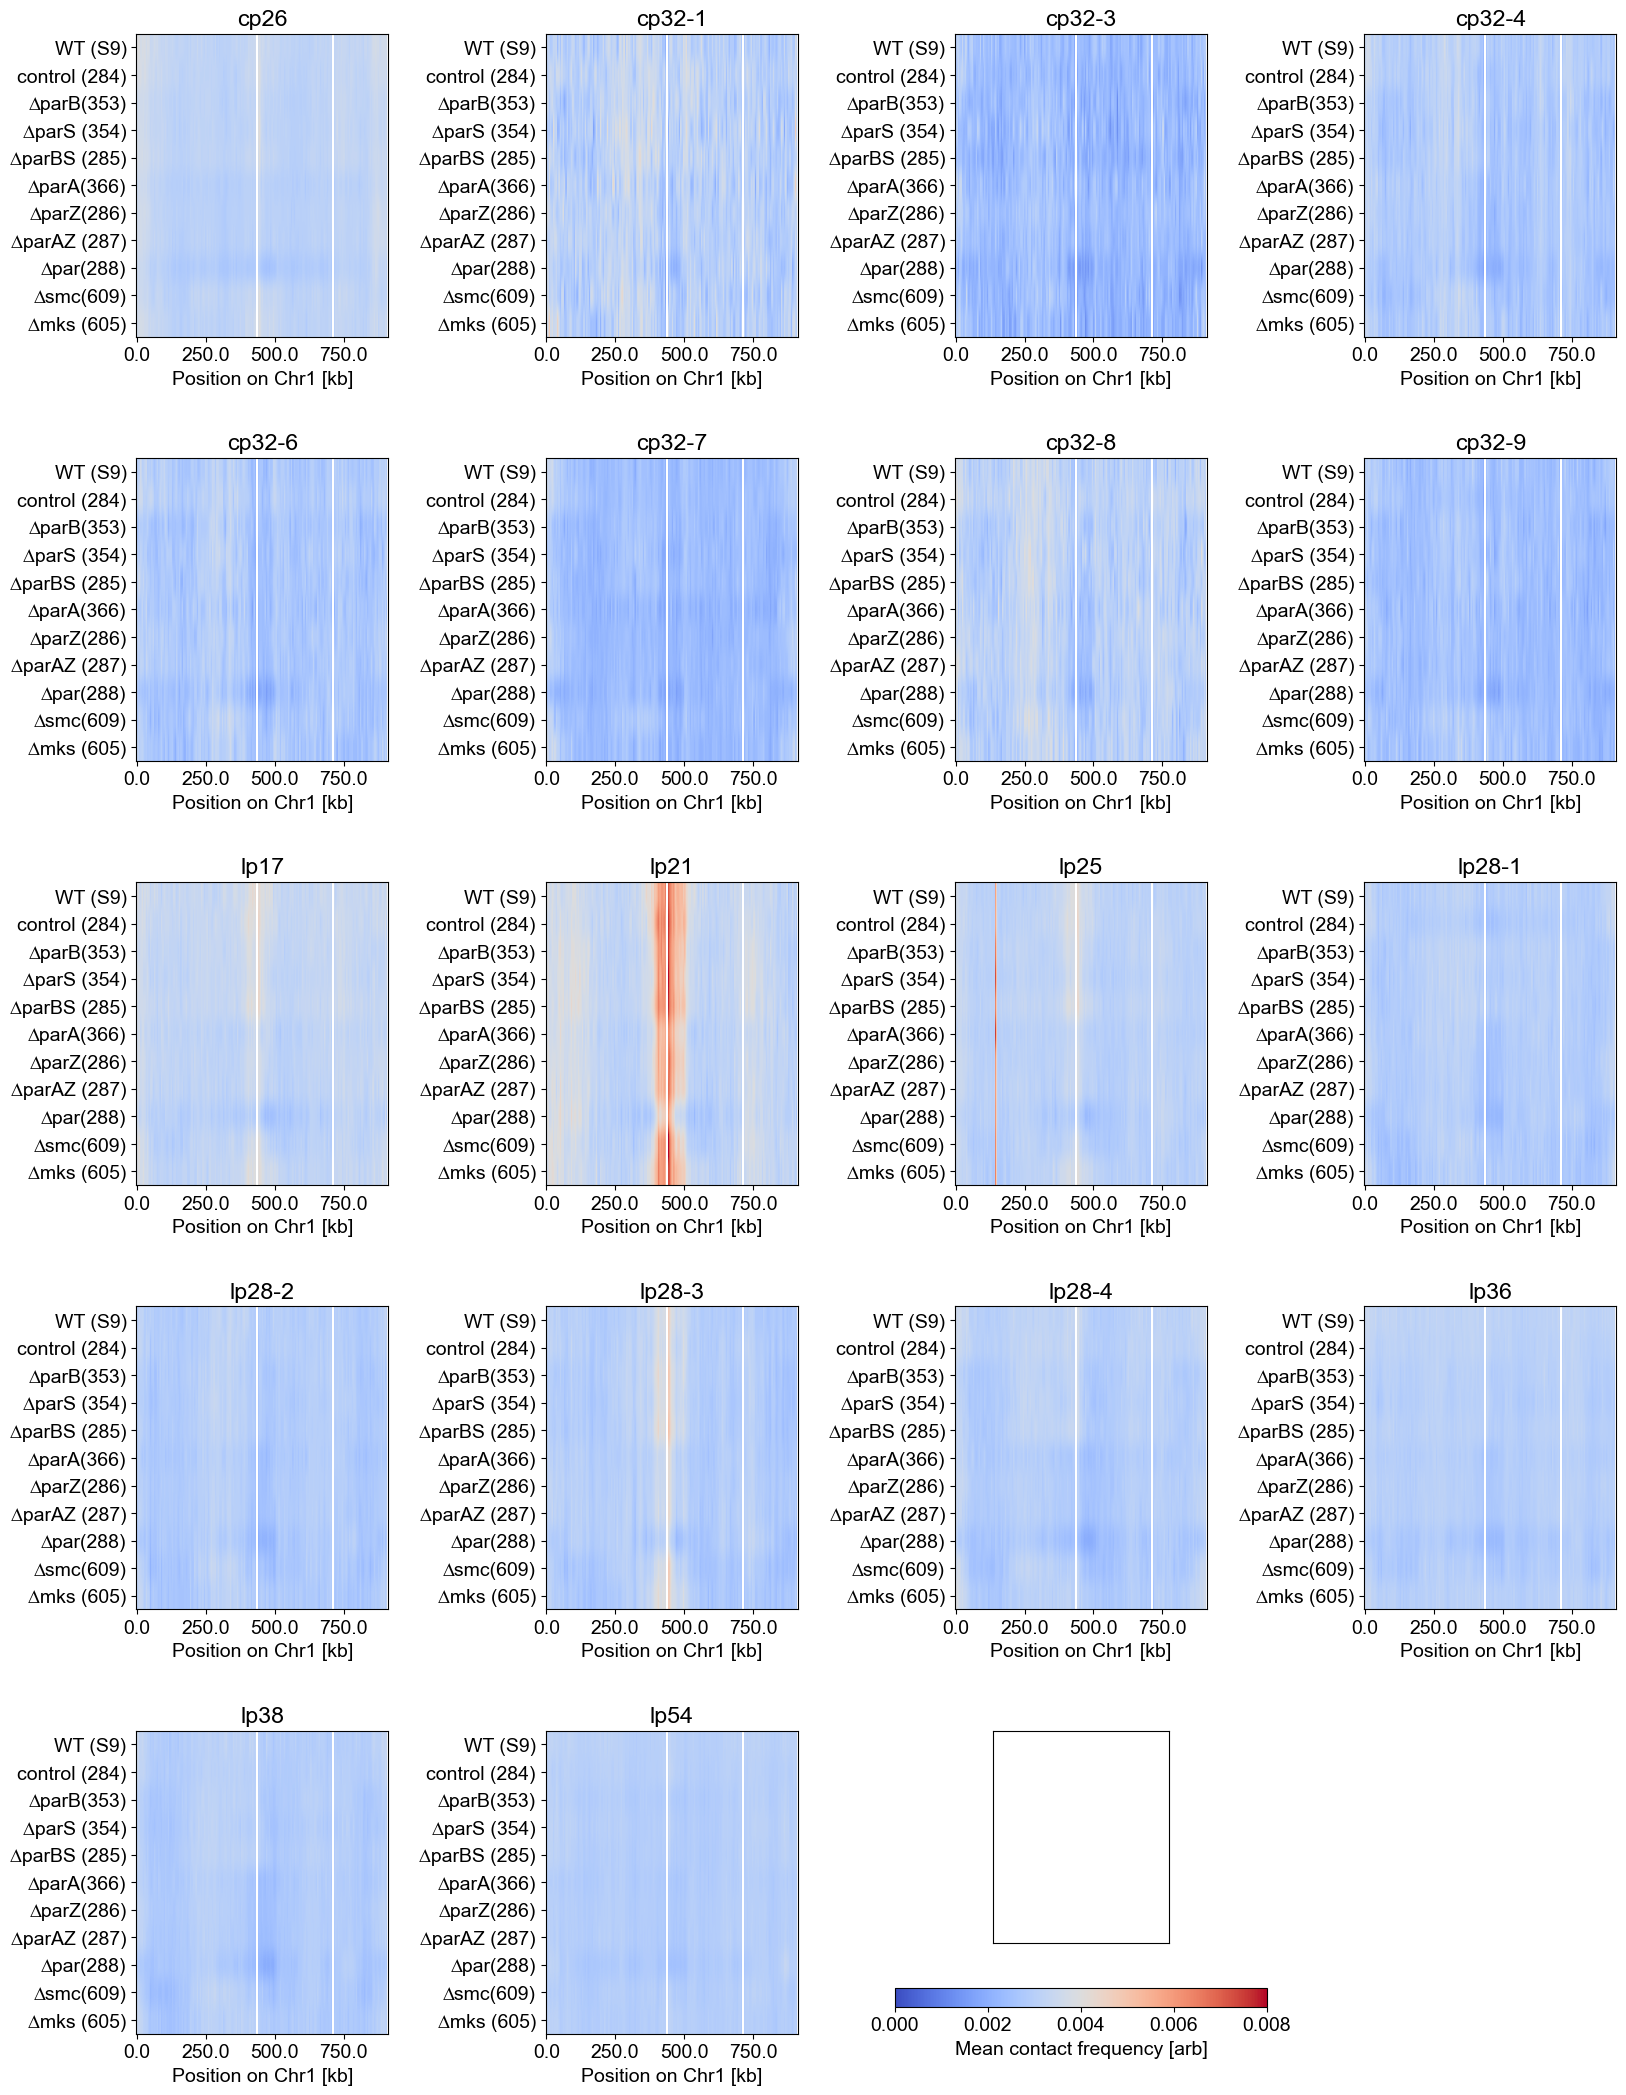

In [20]:
numX = 4
numY = 5
fig, gs = gridspec_inches([4]*numX,[4]*numY,wspace=0.1,hspace=0.4)

plt.rcParams.update({'font.size': 14})

for gi, chrom in  zip(range(len(chrom_names)),chrom_names[1:]):
    plt.subplot(gs[gi])
    X = [plasmid_dict[k][chrom] for k in plasmid_dict.keys()]
    plt.imshow(X,cmap='coolwarm',aspect=20,vmax=0.008,vmin=0)
    plt.xticks(np.arange(0,X[0].shape[0],50),np.arange(0,X[0].shape[0],50)*resolution/1000)
    plt.yticks(np.arange(0,len(X)),labels=plasmid_dict.keys())
    plt.xlabel('Position on Chr1 [kb]')
    plt.title(chrom)

plt.subplot(gs[gi+1])    
plt.imshow(np.log(np.zeros_like(X)),cmap='coolwarm',aspect=20,vmax=0.008,vmin=0) 
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.colorbar(orientation='horizontal',label='Mean contact frequency [arb]')  
# plt.savefig(os.path.join(save_folder, f'Strain_plasmid_interaction_combined.pdf'),bbox_inches='tight')